## Basic analysis of MTurk Experiments

In [39]:
# import
import json
import pandas as pd
from datetime import datetime
from bs4 import BeautifulSoup
DATEFORMAT = "%m/%d/%Y, %I:%M:%S %p"

In [40]:
# load data
file = "06_19_2023_10pm.json"
with open("./mturk_logs/" + file) as f:
    logs = json.load(f)["logs"]

In [41]:
# helper functions
def completed_survey(log):
    return log["completedSurvey"]

def num_messages(log):
    if log["condition"] == "treatment":
        return sum([e["isUser"] for e in log["chatLog"]["current"]["main"]])
    else:
        return "-"

def num_help(log):
    if log["condition"] == "treatment":
        if "help" in log["chatLog"]["current"]:
            return len(log["chatLog"]["current"]["help"])
        else:
            return 0
    else:
        return "-"

def test_score(log):
    score = 0
    for quest in log["knowledgeAnswers"]:
        qlog = log["knowledgeAnswers"][quest]
        score += (qlog["answer"] == qlog["solution"])
    return score

def time_total(log):
    learning = datetime.strptime(log["timestamps"]["enterMain"], DATEFORMAT)
    completion = datetime.strptime(log["timestamps"]["completion"], DATEFORMAT)
    return round((completion - learning).total_seconds() / 60.0, 1)

def time_on_learning(log):
    learning = datetime.strptime(log["timestamps"]["enterMain"], DATEFORMAT)
    knowledge = datetime.strptime(log["timestamps"]["enterKnowledge"], DATEFORMAT)
    return round((knowledge - learning).total_seconds() / 60.0, 1)

def time_on_exam(log):
    knowledge = datetime.strptime(log["timestamps"]["enterKnowledge"], DATEFORMAT)
    survey = datetime.strptime(log["timestamps"]["enterSurvey"], DATEFORMAT)
    return round((survey - knowledge).total_seconds() / 60.0, 1)

def exam_switches(log):
    switches = 0
    knowledge = datetime.strptime(log["timestamps"]["enterKnowledge"], DATEFORMAT)
    survey = datetime.strptime(log["timestamps"]["enterSurvey"], DATEFORMAT)
    if not "tabSwitches" in log:
        return 0
    for switch in log["tabSwitches"]:
        if switch[0] == "exit":
            time = datetime.strptime(switch[1], DATEFORMAT)
            if (knowledge < time) and (time < survey):
                switches += 1
    return switches

def total_switches(log):
    switches = 0
    learning = datetime.strptime(log["timestamps"]["enterMain"], DATEFORMAT)
    if not "tabSwitches" in log:
        return 0
    for switch in log["tabSwitches"]:
        if switch[0] == "exit":
            time = datetime.strptime(switch[1], DATEFORMAT)
            if (learning < time):
                switches += 1
    return switches

def compile_dialog(log):
    assert log["condition"] == "treatment", "dialog only for treatment"
    messages = []
    for m in log["chatLog"]["current"]["main"]:
        time = datetime.strptime(m["date"], DATEFORMAT)
        messages.append((time, m["text"]))
    for m in log["chatLog"]["current"].get("help", []):
        time = datetime.strptime(m["date"], DATEFORMAT)
        messages.append((time, m["text"]))
    for m in log["chatLog"]["current"].get("supervisor", []):
        time = datetime.strptime(m["date"], DATEFORMAT)
        messages.append((time, m.get("text", "Professor: NO LLM RESPONSE")))
    messages.sort()
    for m in messages:
        print(m[1])

### Compile results

In [42]:
rlogs = [logs[k] for k in logs if completed_survey(logs[k])]

In [43]:
# performance df
perf_df = pd.DataFrame()
perf_df["surveyToken"] = [l["surveyToken"] for l in rlogs]
perf_df["condition"] = [l["condition"] for l in rlogs]
perf_df["completed_survey"] = [completed_survey(l) for l in rlogs]
perf_df["time_learning"] = [time_on_learning(l) for l in rlogs]
perf_df["num_messages"] = [num_messages(l) for l in rlogs]
perf_df["num_help"] = [num_help(l) for l in rlogs]
perf_df["test_score"] = [test_score(l) for l in rlogs]
perf_df["total_switches"] = [total_switches(l) for l in rlogs]
perf_df["exam_switches"] = [exam_switches(l) for l in rlogs]
perf_df["time_exam"] = [time_on_exam(l) for l in rlogs]
perf_df["time_total"] = [time_total(l) for l in rlogs]
perf_df["creation_time"] = [l["timestamps"]["creation"] for l in rlogs]
perf_df["completion_time"] = [l["timestamps"]["completion"] for l in rlogs]


perf_df = perf_df.sort_values("condition")
perf_df.to_csv("./tmp/perf_tmp.csv", index=False)
perf_df

,surveyToken,condition,completed_survey,time_learning,num_messages,num_help,test_score,total_switches,exam_switches,time_exam,time_total,creation_time,completion_time
2,a03c3291-6cd0,control,True,8.8,-,-,4,0,0,1.7,11.8,"6/19/2023, 3:18:15 PM","6/19/2023, 3:30:20 PM"
4,96f29067-2ee8,control,True,0.7,-,-,7,11,10,4.5,6.2,"6/19/2023, 10:42:57 PM","6/19/2023, 10:49:29 PM"
8,3007c39a-2e3c,control,True,0.5,-,-,5,1,0,1.0,2.0,"6/19/2023, 9:08:00 PM","6/19/2023, 9:10:03 PM"
9,9cb8794c-5015,control,True,3.9,-,-,6,0,0,1.3,5.8,"6/19/2023, 8:18:00 PM","6/19/2023, 8:24:48 PM"
10,04110027-e8db,control,True,8.6,-,-,6,0,0,1.0,10.7,"6/19/2023, 7:04:09 PM","6/19/2023, 7:15:22 PM"
11,b097e1d4-ddef,control,True,3.1,-,-,5,0,0,0.6,4.4,"6/19/2023, 2:18:22 PM","6/19/2023, 2:23:00 PM"
12,bf7ed4e5-ea75,control,True,7.4,-,-,7,10,8,2.4,10.3,"6/19/2023, 12:30:14 PM","6/19/2023, 12:54:56 PM"
13,1ec0d1d3-720b,control,True,2.2,-,-,6,2,0,10.9,14.4,"6/19/2023, 5:20:59 PM","6/19/2023, 5:36:02 PM"
0,2b8720c3-7b02,treatment,True,7.0,9,0,5,20,12,21.5,29.6,"6/19/2023, 12:19:05 PM","6/19/2023, 12:49:11 PM"
1,505dee7b-4f53,treatment,True,12.2,13,1,6,2,0,2.9,17.1,"6/19/2023, 12:18:22 PM","6/19/2023, 12:35:41 PM"


In [44]:
# basic survey responses (Q1-4 + Q18)
base_df = pd.DataFrame()
base_df["surveyToken"] = [l["surveyToken"] for l in rlogs]
base_df["condition"] = [l["condition"] for l in rlogs]

# basic answers
for q in ["q1", "q2", "q3", "q4"]:
    qtext = BeautifulSoup(rlogs[0]["surveyAnswers"][q]["question"], "html").text
    base_df[qtext] = [l["surveyAnswers"][q]["answer"] for l in rlogs]

# get open response comments
feedback = []
qtext = BeautifulSoup(rlogs[0]["surveyAnswers"]["q18"]["question"], "html").text
for log in rlogs:
    if type(log["surveyAnswers"]["q18"]) != str:
        feedback.append(log["surveyAnswers"]["q18"]["answer"])
    else:
        feedback.append("-")
base_df[qtext] = feedback

base_df = base_df.sort_values("condition")
base_df.to_csv("./tmp/base_tmp.csv", index=False)
base_df

,surveyToken,condition,Q1: I was really engaged in the learning process.,Q2: It was difficult to learn this lesson.,Q3: I have a deep understanding of the concepts in the lesson.,Q4: I remember what I learned in the lesson.,Q18: Please let us know if you have any other suggestions or comments.
2,a03c3291-6cd0,control,Agree,Agree,Disagree,Neutral,-
4,96f29067-2ee8,control,Strongly Agree,Agree,Agree,Strongly Agree,None
8,3007c39a-2e3c,control,Agree,Strongly Agree,Agree,Agree,-
9,9cb8794c-5015,control,Strongly Agree,Agree,Neutral,Neutral,none
10,04110027-e8db,control,Strongly Agree,Disagree,Disagree,Strongly Agree,None.
11,b097e1d4-ddef,control,Strongly Agree,Strongly Disagree,Strongly Disagree,Agree,I have no comments or suggestions.
12,bf7ed4e5-ea75,control,Strongly Agree,Neutral,Agree,Agree,-
13,1ec0d1d3-720b,control,Agree,Disagree,Agree,Agree,NONE
0,2b8720c3-7b02,treatment,Agree,Agree,Strongly Agree,Agree,In this survey is very good and innovative.
1,505dee7b-4f53,treatment,Agree,Disagree,Agree,Strongly Agree,Nothing I can think of


In [45]:
# treatment survey responses (Q5-17)
treatment_df = pd.DataFrame()
tlogs = [l for l in rlogs if l["condition"] == "treatment"]
treatment_df["surveyToken"] = [l["surveyToken"] for l in tlogs]
treatment_df["condition"] = [l["condition"] for l in tlogs]

for q in ["q" + str(i) for i in range(5, 18)]:
    qtext = BeautifulSoup(tlogs[0]["surveyAnswers"][q]["question"], "html").text
    treatment_df[qtext] = [l["surveyAnswers"][q]["answer"] for l in tlogs]

treatment_df = treatment_df.sort_values("condition")
treatment_df.to_csv("./tmp/treatment_tmp.csv", index=False)
treatment_df

,surveyToken,condition,Q5: I interacted with the student chatbot frequently in the learning process.,Q6: I interacted with the professor chatbot frequently in the learning process.,Q7: I found the student chatbot interrupting my learning process.,Q8: I found the professor chatbot interrupting my learning process.,Q9: Teaching the student chatbot improved my understanding of the lesson.,Q10: Teaching the student chatbot helped me remember the lesson.,Q11: I enjoyed teaching the student chatbot.,Q12: The interface of the student chatbot was intuitive.,Q13: The interface of the professor chatbot was intuitive.,Q14: The student chatbot behaves in a reasonable manner.,Q15: The professor chatbot behaves in a reasonable manner.,Q16: I felt as if I was teaching a real student.,Q17: I would like to interact with a student chatbot in the future when learning new lessons.
0,2b8720c3-7b02,treatment,Agree,Agree,Strongly Agree,Agree,Agree,Agree,Strongly Agree,Agree,Agree,Strongly Agree,Agree,Agree,Strongly Agree
1,505dee7b-4f53,treatment,Agree,Agree,Disagree,Disagree,Agree,Agree,Agree,Agree,Strongly Agree,Strongly Agree,Strongly Agree,Agree,Strongly Agree
2,ef49c9b9-f4b5,treatment,Agree,Neutral,Agree,Agree,Strongly Agree,Agree,Strongly Agree,Strongly Agree,Strongly Agree,Agree,Neutral,Strongly Agree,Agree
3,c825dae7-5150,treatment,Strongly Agree,Strongly Disagree,Disagree,Strongly Disagree,Strongly Agree,Strongly Agree,Strongly Agree,Strongly Agree,Neutral,Strongly Agree,Strongly Agree,Agree,Strongly Agree
4,26f3bcab-b3b3,treatment,Neutral,Agree,Neutral,Neutral,Agree,Neutral,Strongly Agree,Agree,Strongly Agree,Agree,Strongly Agree,Agree,Agree
5,600ce1c3-0193,treatment,Strongly Agree,Agree,Agree,Strongly Agree,Strongly Agree,Agree,Agree,Strongly Agree,Strongly Agree,Agree,Agree,Neutral,Strongly Agree


In [49]:
# demographics survey responses
demo_df = pd.DataFrame()
demo_df["surveyToken"] = [l["surveyToken"] for l in rlogs]
demo_df["condition"] = [l["condition"] for l in rlogs]

for q in ["q1", "q2", "q3", "q4"]:
    qtext = BeautifulSoup(tlogs[0]["demographicsAnswers"][q]["question"], "html").text
    demo_df[qtext] = [l["demographicsAnswers"][q]["answer"] for l in rlogs]

demo_df = demo_df.sort_values("condition")
demo_df.to_csv("./tmp/demo_tmp.csv", index=False)
demo_df

,surveyToken,condition,What is your age?,What is your gender?,What is your highest educational degree?,What is your field of work/study?
2,a03c3291-6cd0,control,Over 55,male,High School Diploma or Equivalent,Arts
4,96f29067-2ee8,control,46 - 55,male,Bachelor's/Professional Degree,Computer Science
8,3007c39a-2e3c,control,36 - 45,male,Master's Degree or Higher,Computer Science
9,9cb8794c-5015,control,Over 55,female,High School Diploma or Equivalent,Computer Science
10,04110027-e8db,control,26 - 35,male,Bachelor's/Professional Degree,Business/Management
11,b097e1d4-ddef,control,26 - 35,male,Bachelor's/Professional Degree,Other
12,bf7ed4e5-ea75,control,36 - 45,male,Bachelor's/Professional Degree,Computer Science
13,1ec0d1d3-720b,control,26 - 35,female,Bachelor's/Professional Degree,Health/Medicine
0,2b8720c3-7b02,treatment,26 - 35,male,Bachelor's/Professional Degree,Health/Medicine
1,505dee7b-4f53,treatment,26 - 35,male,High School Diploma or Equivalent,Health/Medicine


### Print Dialogs

In [50]:
if False:  # set to True
    for log in rlogs:
        if log["condition"] == "treatment":
            print(log["surveyToken"])
            print("---------------------------------")
            compile_dialog(log)
            print("")

# P-value between control group and tretement group for Q1 to Q4

In [114]:
# basic survey responses (Q1-4 + Q18)
base_df = pd.DataFrame()
base_df["surveyToken"] = [l["surveyToken"] for l in rlogs]
base_df["condition"] = [l["condition"] for l in rlogs]

# basic answers
for q in ["q1", "q2", "q3", "q4"]:
    qtext = BeautifulSoup(rlogs[0]["surveyAnswers"][q]["question"], "html").text
    base_df[qtext] = [l["surveyAnswers"][q]["answer"] for l in rlogs]

base_df

,surveyToken,condition,Q1: I was really engaged in the learning process.,Q2: It was difficult to learn this lesson.,Q3: I have a deep understanding of the concepts in the lesson.,Q4: I remember what I learned in the lesson.
0,2b8720c3-7b02,treatment,Agree,Agree,Strongly Agree,Agree
1,505dee7b-4f53,treatment,Agree,Disagree,Agree,Strongly Agree
2,a03c3291-6cd0,control,Agree,Agree,Disagree,Neutral
3,ef49c9b9-f4b5,treatment,Agree,Neutral,Agree,Strongly Agree
4,96f29067-2ee8,control,Strongly Agree,Agree,Agree,Strongly Agree
5,c825dae7-5150,treatment,Strongly Agree,Disagree,Strongly Agree,Strongly Agree
6,26f3bcab-b3b3,treatment,Strongly Agree,Neutral,Strongly Agree,Agree
7,600ce1c3-0193,treatment,Strongly Agree,Agree,Strongly Agree,Strongly Agree
8,3007c39a-2e3c,control,Agree,Strongly Agree,Agree,Agree
9,9cb8794c-5015,control,Strongly Agree,Agree,Neutral,Neutral


In [126]:
# change "Strongly Agree" in base_df to number 7
base_df = base_df.replace("Strongly Agree", 5)
base_df = base_df.replace("Strongly Disagree", 1)
base_df = base_df.replace("Disagree", 2)
base_df = base_df.replace("Agree", 4)
base_df = base_df.replace("Neutral", 3)


In [127]:
# calculate the p-value for each question between the two conditions using mann-whitney u test
from scipy.stats import mannwhitneyu
p_q1_q4 = []
for q in base_df.columns[2:]:
    print(q)
    p_q1_q4.append(mannwhitneyu(base_df[base_df["condition"] == "control"][q], base_df[base_df["condition"] == "treatment"][q]).pvalue)
    print(mannwhitneyu(base_df[base_df["condition"] == "control"][q], base_df[base_df["condition"] == "treatment"][q]))
p_q1_q4


Q1: I was really engaged in the learning process.
MannwhitneyuResult(statistic=27.0, pvalue=0.7072304570410443)
Q2: It was difficult to learn this lesson.
MannwhitneyuResult(statistic=26.0, pvalue=0.8404507706591073)
Q3: I have a deep understanding of the concepts in the lesson.
MannwhitneyuResult(statistic=4.0, pvalue=0.007925308046327234)
Q4: I remember what I learned in the lesson.
MannwhitneyuResult(statistic=12.0, pvalue=0.10607746368097135)


[0.7072304570410443,
 0.8404507706591073,
 0.007925308046327234,
 0.10607746368097135]

[4.625, 3.125, 3.0, 4.0]
[4.5, 3.0, 4.666666666666667, 4.666666666666667]


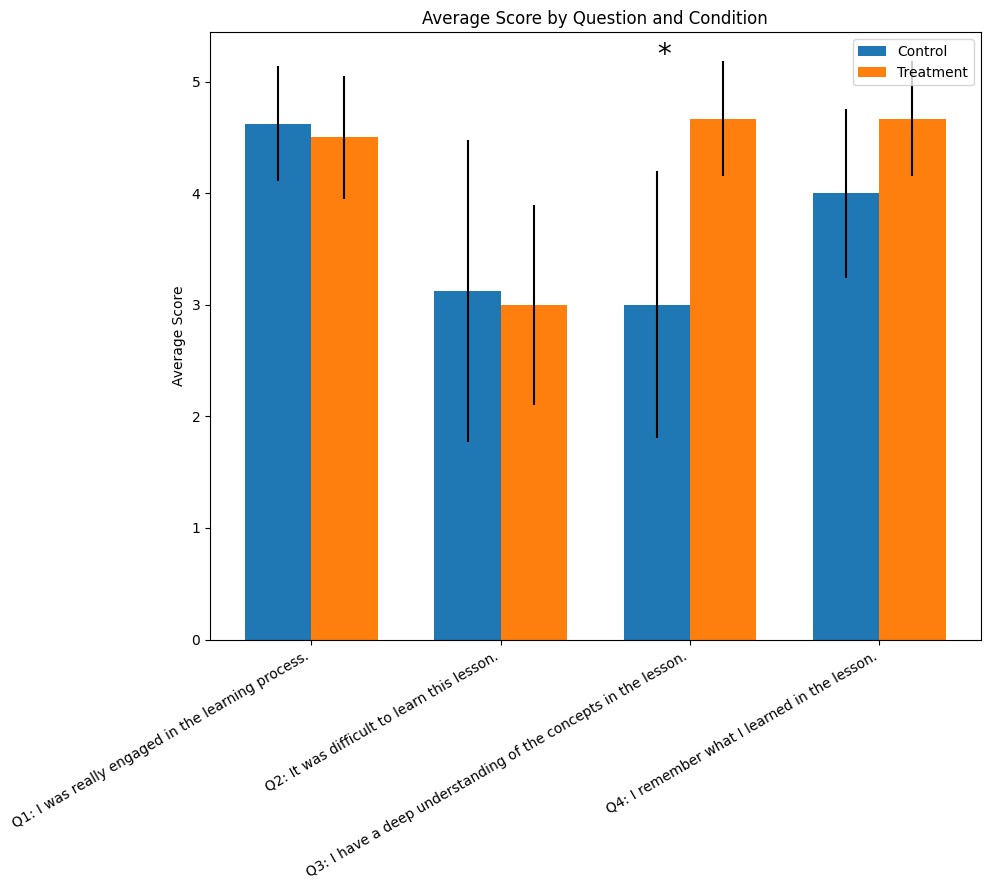

In [128]:
# plot a bar chart of the average score and std for each question in each condition
import matplotlib.pyplot as plt
import numpy as np

# get the average score for each question in each condition
control_avg = []
treatment_avg = []
for q in base_df.columns[2:]:
    control_avg.append(base_df[base_df["condition"] == "control"][q].mean())
    treatment_avg.append(base_df[base_df["condition"] == "treatment"][q].mean())

print(control_avg)
print(treatment_avg)

# get the std for each question in each condition
control_std = []
treatment_std = []
for q in base_df.columns[2:]:
    control_std.append(base_df[base_df["condition"] == "control"][q].std())
    treatment_std.append(base_df[base_df["condition"] == "treatment"][q].std())

# plot the bar chart
x = np.arange(len(base_df.columns[2:]))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 9))
rects1 = ax.bar(x - width / 2, control_avg, width, label="Control", yerr=control_std)
rects2 = ax.bar(x + width / 2, treatment_avg, width, label="Treatment", yerr=treatment_std)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel("Average Score")
ax.set_title("Average Score by Question and Condition")
ax.set_xticks(x)

# rotate the x-axis labels
ax.set_xticklabels(base_df.columns[2:], rotation=30, ha="right")
ax.legend()

# add the p-values to the plot
# for i, v in enumerate(p_q1_q4):
#     ax.text(i - width / 2, control_avg[i] + 0.1, str(round(v, 3)), color="blue", fontweight="bold")
#     ax.text(i + width / 2, treatment_avg[i] + 0.1, str(round(v, 3)), color="blue", fontweight="bold")
for i in range(len(p_q1_q4)):
    if p_q1_q4[i] < 0.05:
        ax.text(x[i] - width/2, max(control_avg[i], treatment_avg[i]) + 0.5, "*", fontsize=20)

fig.tight_layout()

plt.show() 


In [129]:
treatment_df = pd.DataFrame()
tlogs = [l for l in rlogs if l["condition"] == "treatment"]
treatment_df["surveyToken"] = [l["surveyToken"] for l in tlogs]
treatment_df["condition"] = [l["condition"] for l in tlogs]

for q in ["q" + str(i) for i in range(5, 18)]:
    qtext = BeautifulSoup(tlogs[0]["surveyAnswers"][q]["question"], "html").text
    treatment_df[qtext] = [l["surveyAnswers"][q]["answer"] for l in tlogs]
    
treatment_df

,surveyToken,condition,Q5: I interacted with the student chatbot frequently in the learning process.,Q6: I interacted with the professor chatbot frequently in the learning process.,Q7: I found the student chatbot interrupting my learning process.,Q8: I found the professor chatbot interrupting my learning process.,Q9: Teaching the student chatbot improved my understanding of the lesson.,Q10: Teaching the student chatbot helped me remember the lesson.,Q11: I enjoyed teaching the student chatbot.,Q12: The interface of the student chatbot was intuitive.,Q13: The interface of the professor chatbot was intuitive.,Q14: The student chatbot behaves in a reasonable manner.,Q15: The professor chatbot behaves in a reasonable manner.,Q16: I felt as if I was teaching a real student.,Q17: I would like to interact with a student chatbot in the future when learning new lessons.
0,2b8720c3-7b02,treatment,Agree,Agree,Strongly Agree,Agree,Agree,Agree,Strongly Agree,Agree,Agree,Strongly Agree,Agree,Agree,Strongly Agree
1,505dee7b-4f53,treatment,Agree,Agree,Disagree,Disagree,Agree,Agree,Agree,Agree,Strongly Agree,Strongly Agree,Strongly Agree,Agree,Strongly Agree
2,ef49c9b9-f4b5,treatment,Agree,Neutral,Agree,Agree,Strongly Agree,Agree,Strongly Agree,Strongly Agree,Strongly Agree,Agree,Neutral,Strongly Agree,Agree
3,c825dae7-5150,treatment,Strongly Agree,Strongly Disagree,Disagree,Strongly Disagree,Strongly Agree,Strongly Agree,Strongly Agree,Strongly Agree,Neutral,Strongly Agree,Strongly Agree,Agree,Strongly Agree
4,26f3bcab-b3b3,treatment,Neutral,Agree,Neutral,Neutral,Agree,Neutral,Strongly Agree,Agree,Strongly Agree,Agree,Strongly Agree,Agree,Agree
5,600ce1c3-0193,treatment,Strongly Agree,Agree,Agree,Strongly Agree,Strongly Agree,Agree,Agree,Strongly Agree,Strongly Agree,Agree,Agree,Neutral,Strongly Agree


In [130]:
# change "Strongly Agree" in treatment_df to number 7
treatment_df = treatment_df.replace("Strongly Agree", 5)
treatment_df = treatment_df.replace("Strongly Disagree", 1)
treatment_df = treatment_df.replace("Disagree", 2)
treatment_df = treatment_df.replace("Agree", 4)
treatment_df = treatment_df.replace("Neutral", 3)


[4.166666666666667, 3.3333333333333335, 3.3333333333333335, 3.1666666666666665, 4.5, 4.0, 4.666666666666667, 4.5, 4.5, 4.5, 4.333333333333333, 4.0, 4.666666666666667]


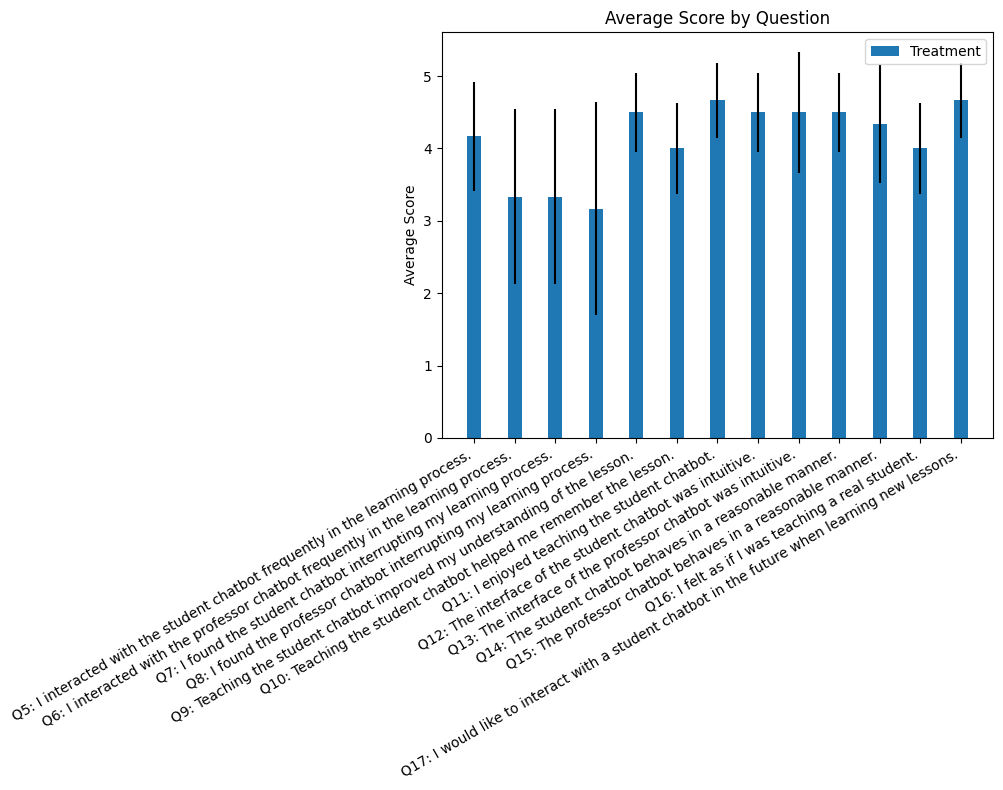

In [131]:
# plot a bar chart of the average score and std for each question
import matplotlib.pyplot as plt
import numpy as np

# get the average score for each question
treatment_avg = []
for q in treatment_df.columns[2:]:
    treatment_avg.append(treatment_df[q].mean())

print(treatment_avg)

# get the std for each question
treatment_std = []
for q in treatment_df.columns[2:]:
    treatment_std.append(treatment_df[q].std())

# plot the bar chart
x = np.arange(len(treatment_df.columns[2:]))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 8))
rects1 = ax.bar(x, treatment_avg, width, label="Treatment", yerr=treatment_std)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel("Average Score")
ax.set_title("Average Score by Question")
ax.set_xticks(x)

# rotate the x-axis labels
ax.set_xticklabels(treatment_df.columns[2:], rotation=30, ha="right")
ax.legend()

fig.tight_layout()

plt.show()

In [121]:
# performance df
perf_df = pd.DataFrame()
perf_df["surveyToken"] = [l["surveyToken"] for l in rlogs]
perf_df["condition"] = [l["condition"] for l in rlogs]
perf_df["completed_survey"] = [completed_survey(l) for l in rlogs]
perf_df["time_learning"] = [time_on_learning(l) for l in rlogs]
perf_df["num_messages"] = [num_messages(l) for l in rlogs]
perf_df["num_help"] = [num_help(l) for l in rlogs]
perf_df["test_score"] = [test_score(l) for l in rlogs]
perf_df["total_switches"] = [total_switches(l) for l in rlogs]
perf_df["exam_switches"] = [exam_switches(l) for l in rlogs]
perf_df["time_exam"] = [time_on_exam(l) for l in rlogs]
perf_df["time_total"] = [time_total(l) for l in rlogs]
perf_df["creation_time"] = [l["timestamps"]["creation"] for l in rlogs]
perf_df["completion_time"] = [l["timestamps"]["completion"] for l in rlogs]

perf_df

,surveyToken,condition,completed_survey,time_learning,num_messages,num_help,test_score,total_switches,exam_switches,time_exam,time_total,creation_time,completion_time
0,2b8720c3-7b02,treatment,True,7.0,9,0,5,20,12,21.5,29.6,"6/19/2023, 12:19:05 PM","6/19/2023, 12:49:11 PM"
1,505dee7b-4f53,treatment,True,12.2,13,1,6,2,0,2.9,17.1,"6/19/2023, 12:18:22 PM","6/19/2023, 12:35:41 PM"
2,a03c3291-6cd0,control,True,8.8,-,-,4,0,0,1.7,11.8,"6/19/2023, 3:18:15 PM","6/19/2023, 3:30:20 PM"
3,ef49c9b9-f4b5,treatment,True,18.9,5,0,5,4,3,29.6,49.4,"6/19/2023, 8:15:06 PM","6/19/2023, 9:06:49 PM"
4,96f29067-2ee8,control,True,0.7,-,-,7,11,10,4.5,6.2,"6/19/2023, 10:42:57 PM","6/19/2023, 10:49:29 PM"
5,c825dae7-5150,treatment,True,7.6,9,0,7,25,16,4.8,13.8,"6/19/2023, 5:02:34 PM","6/19/2023, 5:17:06 PM"
6,26f3bcab-b3b3,treatment,True,0.2,0,0,6,11,11,4.0,5.5,"6/19/2023, 10:27:36 PM","6/19/2023, 10:33:18 PM"
7,600ce1c3-0193,treatment,True,3.6,1,0,7,24,22,16.7,22.1,"6/19/2023, 3:53:34 PM","6/19/2023, 4:17:06 PM"
8,3007c39a-2e3c,control,True,0.5,-,-,5,1,0,1.0,2.0,"6/19/2023, 9:08:00 PM","6/19/2023, 9:10:03 PM"
9,9cb8794c-5015,control,True,3.9,-,-,6,0,0,1.3,5.8,"6/19/2023, 8:18:00 PM","6/19/2023, 8:24:48 PM"


In [138]:
#replace '-' with 0
perf_df = perf_df.replace("-", 0)
perf_df

,surveyToken,condition,completed_survey,time_learning,num_messages,num_help,test_score,total_switches,exam_switches,time_exam,time_total,creation_time,completion_time
0,2b8720c3-7b02,treatment,True,7.0,9,0,5,20,12,21.5,29.6,"6/19/2023, 12:19:05 PM","6/19/2023, 12:49:11 PM"
1,505dee7b-4f53,treatment,True,12.2,13,1,6,2,0,2.9,17.1,"6/19/2023, 12:18:22 PM","6/19/2023, 12:35:41 PM"
2,a03c3291-6cd0,control,True,8.8,0,0,4,0,0,1.7,11.8,"6/19/2023, 3:18:15 PM","6/19/2023, 3:30:20 PM"
3,ef49c9b9-f4b5,treatment,True,18.9,5,0,5,4,3,29.6,49.4,"6/19/2023, 8:15:06 PM","6/19/2023, 9:06:49 PM"
4,96f29067-2ee8,control,True,0.7,0,0,7,11,10,4.5,6.2,"6/19/2023, 10:42:57 PM","6/19/2023, 10:49:29 PM"
5,c825dae7-5150,treatment,True,7.6,9,0,7,25,16,4.8,13.8,"6/19/2023, 5:02:34 PM","6/19/2023, 5:17:06 PM"
6,26f3bcab-b3b3,treatment,True,0.2,0,0,6,11,11,4.0,5.5,"6/19/2023, 10:27:36 PM","6/19/2023, 10:33:18 PM"
7,600ce1c3-0193,treatment,True,3.6,1,0,7,24,22,16.7,22.1,"6/19/2023, 3:53:34 PM","6/19/2023, 4:17:06 PM"
8,3007c39a-2e3c,control,True,0.5,0,0,5,1,0,1.0,2.0,"6/19/2023, 9:08:00 PM","6/19/2023, 9:10:03 PM"
9,9cb8794c-5015,control,True,3.9,0,0,6,0,0,1.3,5.8,"6/19/2023, 8:18:00 PM","6/19/2023, 8:24:48 PM"


In [139]:
# calculate the p-value for each column between the two conditions using t-test except columns 'creation_time' and 'completion_time'
from scipy.stats import ttest_ind
p_q5_q18 = []
for q in perf_df.columns[3:-2]:
    print(q)
    print(perf_df[perf_df["condition"] == "control"][q])
    print(perf_df[perf_df["condition"] == "treatment"][q])
    p_q5_q18.append(ttest_ind(perf_df[perf_df["condition"] == "control"][q], perf_df[perf_df["condition"] == "treatment"][q])[1])
    print(ttest_ind(perf_df[perf_df["condition"] == "control"][q], perf_df[perf_df["condition"] == "treatment"][q]))
p_q5_q18

time_learning
2     8.8
4     0.7
8     0.5
9     3.9
10    8.6
11    3.1
12    7.4
13    2.2
Name: time_learning, dtype: float64
0     7.0
1    12.2
3    18.9
5     7.6
6     0.2
7     3.6
Name: time_learning, dtype: float64
Ttest_indResult(statistic=-1.427870618362606, pvalue=0.1788333985267551)
num_messages
2     0
4     0
8     0
9     0
10    0
11    0
12    0
13    0
Name: num_messages, dtype: int64
0     9
1    13
3     5
5     9
6     0
7     1
Name: num_messages, dtype: int64
Ttest_indResult(statistic=-3.4848458795071475, pvalue=0.004505941528608596)
num_help
2     0
4     0
8     0
9     0
10    0
11    0
12    0
13    0
Name: num_help, dtype: int64
0    0
1    1
3    0
5    0
6    0
7    0
Name: num_help, dtype: int64
Ttest_indResult(statistic=-1.1710800875382397, pvalue=0.2642960660107217)
test_score
2     4
4     7
8     5
9     6
10    6
11    5
12    7
13    6
Name: test_score, dtype: int64
0    5
1    6
3    5
5    7
6    6
7    7
Name: test_score, dtype: int64
Ttest_in

[0.1788333985267551,
 0.004505941528608596,
 0.2642960660107217,
 0.6447933826282519,
 0.015387466031579785,
 0.026351408525139015,
 0.027271985465600095,
 0.02211796671329528]

[4.4, 0.0, 0.0, 5.75, 3.0, 2.25, 2.925, 8.200000000000001]
[8.25, 6.166666666666667, 0.16666666666666666, 6.0, 14.333333333333334, 10.666666666666666, 13.25, 22.916666666666668]


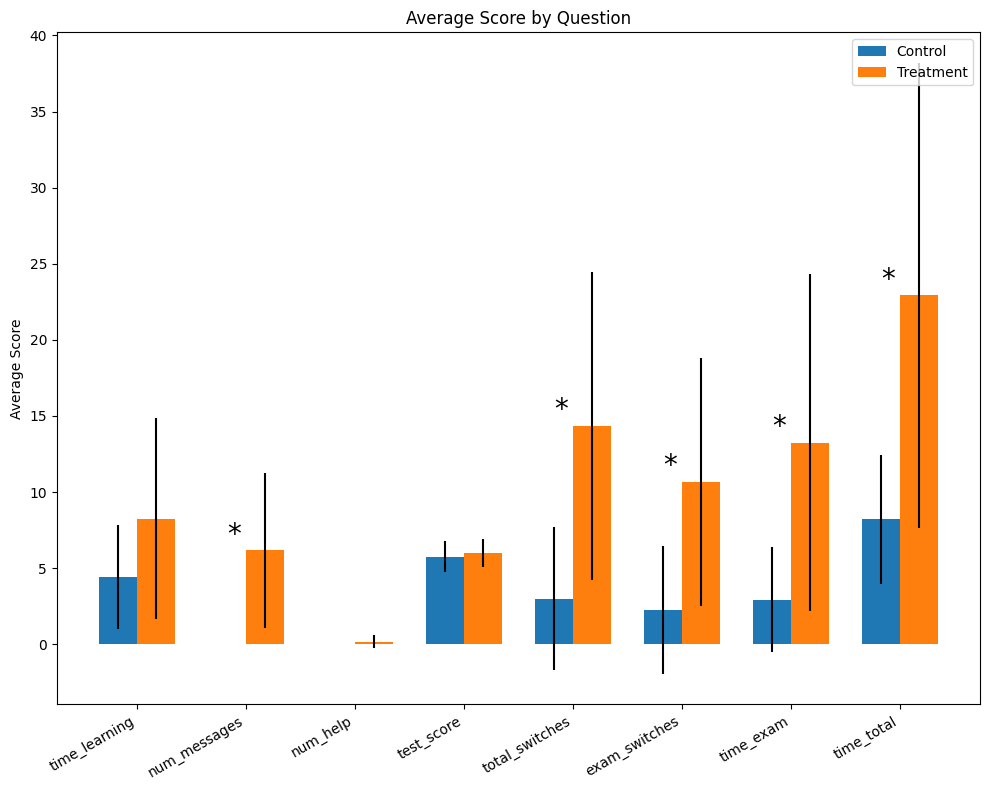

In [140]:
# plot a bar chart of the average score and std for each question in each condition
import matplotlib.pyplot as plt
import numpy as np

# get the average score for each question in each condition from columns 'q5' to 'q18'
control_avg = []
for q in perf_df.columns[3:-2]:
    control_avg.append(perf_df[perf_df["condition"] == "control"][q].mean())

treatment_avg = []
for q in perf_df.columns[3:-2]:
    treatment_avg.append(perf_df[perf_df["condition"] == "treatment"][q].mean())

print(control_avg)
print(treatment_avg)

# get the std for each question in each condition from columns 'q5' to 'q18'
control_std = []
for q in perf_df.columns[3:-2]:
    control_std.append(perf_df[perf_df["condition"] == "control"][q].std())

treatment_std = []
for q in perf_df.columns[3:-2]:
    treatment_std.append(perf_df[perf_df["condition"] == "treatment"][q].std())

# plot the bar chart
x = np.arange(len(perf_df.columns[3:-2]))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 8))
rects1 = ax.bar(x - width/2, control_avg, width, label="Control", yerr=control_std)
rects2 = ax.bar(x + width/2, treatment_avg, width, label="Treatment", yerr=treatment_std)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel("Average Score")
ax.set_title("Average Score by Question")
ax.set_xticks(x)

# rotate the x-axis labels
ax.set_xticklabels(perf_df.columns[3:-2], rotation=30, ha="right")
ax.legend()

# add p-value to the plot
for i in range(len(p_q5_q18)):
    if p_q5_q18[i] < 0.05:
        ax.text(x[i] - width/2, max(control_avg[i], treatment_avg[i]) + 0.5, "*", fontsize=20)


fig.tight_layout()

plt.show()
